<a href="https://colab.research.google.com/github/yuchen170/GDSC_AI/blob/main/GDSC_AI%E7%A4%BE%E8%AA%B2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Step 1
* import libraries

In [58]:
# Step 1.1 code
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten #一些模型內會用到的layer
from keras.callbacks import EarlyStopping, ReduceLROnPlateau #回調函數
from keras.models import Sequential #順序模型
import matplotlib.pyplot as plt # 畫圖用的
import tensorflow as tf # tensorflow!
import pandas as pd # 資料處理&分析的好工具
import numpy as np # 陣列運算、很多的數學函數

* 載入資料集

In [80]:
from google.colab import files
files.upload() #上傳kaggle.json

In [60]:
!pip install -U -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json # 讀取和執行
!kaggle competitions download -c digit-recognizer

digit-recognizer.zip: Skipping, found more recently modified local copy (use --force to force download)


In [61]:
import zipfile
zip_train = zipfile.ZipFile('/content/digit-recognizer.zip', 'r')
zip_train.extractall('/content') # Extract the folder into content folder
zip_train.close()

# Step 2
* Data Visulization

In [62]:
data = pd.read_csv('/content/train.csv')
# Step 2 code
print(data.info()) # 簡單的訊息
print(data.head()) # 前五筆資料
# print(data.tail()) # 後五筆資料
# print(data.describe()) # 關於資料集的統計數據
class_counts = data['label'].value_counts()
print(class_counts) # 各類別的資料筆數

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 785 entries, label to pixel783
dtypes: int64(785)
memory usage: 251.5 MB
None
   label  pixel0  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  \
0      1       0       0       0       0       0       0       0       0   
1      0       0       0       0       0       0       0       0       0   
2      1       0       0       0       0       0       0       0       0   
3      4       0       0       0       0       0       0       0       0   
4      0       0       0       0       0       0       0       0       0   

   pixel8  ...  pixel774  pixel775  pixel776  pixel777  pixel778  pixel779  \
0       0  ...         0         0         0         0         0         0   
1       0  ...         0         0         0         0         0         0   
2       0  ...         0         0         0         0         0         0   
3       0  ...         0         0         0         0         0    

* 資料太多了，為了讓後面訓練速度快一點這裡把資料減少一半
* 大家之後也可以把這段拿掉練習！

In [63]:
class_counts = data['label'].value_counts()
reduce_count = class_counts.min() // 2

reduced_data = pd.DataFrame(columns=data.columns)

for label in class_counts.index:
    class_data = data[data['label'] == label]
    sampled_data = class_data.sample(n=reduce_count, random_state=42)
    reduced_data = reduced_data.append(sampled_data, ignore_index=True)

<ipython-input-63-750f85138a4c>:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  reduced_data = reduced_data.append(sampled_data, ignore_index=True)


In [ ]:
class_counts = reduced_data['label'].value_counts()
print(class_counts)

# Step 3
* Split the data to training and validation

In [64]:
# Step 3 code
# 比例依據不同大小的數據適合的不一樣，通常會讓train的比例在0.7~0.8
train_data = data.head(int(len(reduced_data)*0.8))
val_data = data.tail(int(len(reduced_data)*0.2))

train_labels = train_data.pop('label')
val_labels = val_data.pop('label')

# Step 4
* 轉換資料型態

In [65]:
# Step 4 code
tf_train_data = tf.data.Dataset.from_tensor_slices((train_data.values, train_labels.values))
tf_val_data = tf.data.Dataset.from_tensor_slices((val_data.values, val_labels.values))

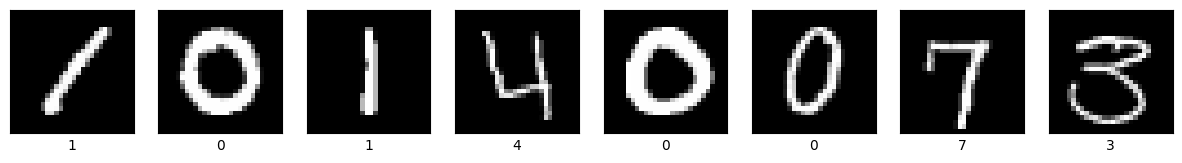

In [66]:
plt.figure(figsize=(15,15))
i = 0
for image, label in tf_train_data.take(8):
    plt.subplot(1,8,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(image.numpy().reshape((28, 28)), cmap='gray')
    plt.xlabel(label.numpy())

    i += 1

# Step 5 Data Preprocessing
* 資料的預處理，讓訓練速度快又精準的關鍵！

In [67]:
# Step 5.1 code
def preprocess_image(image, label):
    image = tf.reshape(image, [28, 28, 1]) #調整大小為28*28*1
    image = tf.cast(image, tf.float32) / 255. #把pixel值縮小到[0,1]區間，pixel值是0-255，所以要縮小255倍！

    return image, label

tf_train_data = tf_train_data.map(preprocess_image)

tf_val_data = tf_val_data.map(preprocess_image)

In [68]:
# Step 5.2 code
def pipeline(tf_data):
    tf_data = tf_data.shuffle(100) #洗牌打亂數據,一次放100個進buffer
    tf_data = tf_data.batch(32) #一個batch包32個數據
    tf_data = tf_data.prefetch(tf.data.experimental.AUTOTUNE) #在訓練前先讀取資料

    return tf_data

tf_train_data = pipeline(tf_train_data)
tf_val_data = pipeline(tf_val_data)

# Step 6 定義模型

In [70]:
# Step 6 code
model = Sequential()
model.add(Conv2D(6, (5, 5), activation='relu', padding='same', input_shape=(28, 28, 1)))  #卷積層，用6個大小為5*5的filter，在模型的第一層需要指定輸入的大小
model.add(MaxPooling2D((2, 2))) # 池化層，用2*2的窗格
model.add(Conv2D(16, (5, 5), activation='relu', padding='valid'))
model.add(MaxPooling2D((2, 2))) #池化層，用2*2的窗格
model.add(Flatten()) #將數據展平成一維才能輸入全連接層
model.add(Dense(120, activation='relu')) #全連接層，120個神經元
model.add(Dense(84, activation='relu')) #全連接層，84個神經元
model.add(Dense(10, activation='softmax')) #輸出層，10個神經元，softmax會將每個類別轉為機率

# Step 7 Compile

In [71]:
model.compile('adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Step 8 訓練

In [72]:
# Step 8.1 code
callbacks = [
    ReduceLROnPlateau(monitor='loss', patience=2, verbose=1), # 如果連續2 epoch 的loss 沒有減少，就降低learning rate
    EarlyStopping(monitor='loss', patience=5, verbose=1), # 如果連續5 epoch 的loss 沒有減少，就提前終止訓練
]

In [73]:
# Step 8.2 code
hist = model.fit(
    tf_train_data, #訓練資料
    validation_data=tf_val_data, #驗證資料
    epochs=10, #訓練次數
    callbacks=callbacks #回調函數
)

Epoch 1/10
475/475 [==============================] - 20s 38ms/step - loss: 0.3881 - accuracy: 0.8830 - val_loss: 0.1642 - val_accuracy: 0.9470 - lr: 0.0010
Epoch 2/10
475/475 [==============================] - 16s 34ms/step - loss: 0.1170 - accuracy: 0.9635 - val_loss: 0.1285 - val_accuracy: 0.9576 - lr: 0.0010
Epoch 3/10
475/475 [==============================] - 14s 29ms/step - loss: 0.0818 - accuracy: 0.9750 - val_loss: 0.0755 - val_accuracy: 0.9760 - lr: 0.0010
Epoch 4/10
475/475 [==============================] - 14s 29ms/step - loss: 0.0636 - accuracy: 0.9796 - val_loss: 0.0768 - val_accuracy: 0.9747 - lr: 0.0010
Epoch 5/10
475/475 [==============================] - 13s 28ms/step - loss: 0.0510 - accuracy: 0.9840 - val_loss: 0.0891 - val_accuracy: 0.9734 - lr: 0.0010
Epoch 6/10
475/475 [==============================] - 14s 29ms/step - loss: 0.0406 - accuracy: 0.9875 - val_loss: 0.0694 - val_accuracy: 0.9768 - lr: 0.0010
Epoch 7/10
475/475 [==============================] - 19s 

# Step 9 訓練結果

Training accuracy: 0.993938
Validation accuracy: 0.981813


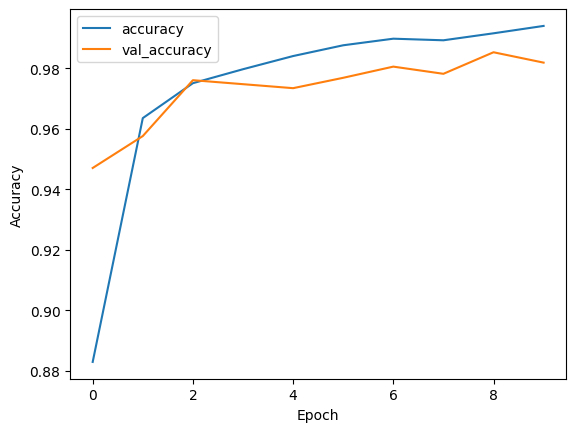

In [77]:
plt.plot(hist.history['accuracy'], label='accuracy')
plt.plot(hist.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

print('Training accuracy: %f' % hist.history['accuracy'][-1])
print('Validation accuracy: %f' % hist.history['val_accuracy'][-1])

Training loss: 0.019529
Validation loss: 0.070203


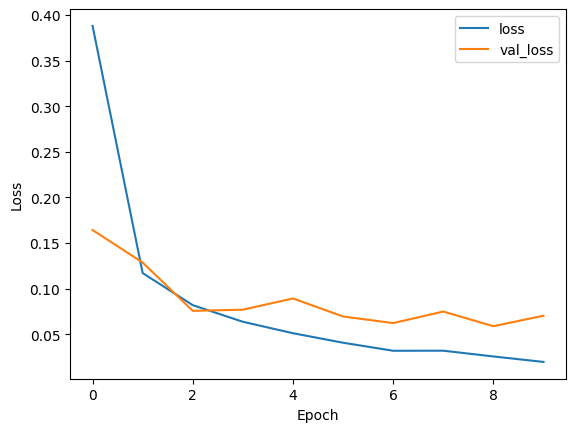

In [78]:
plt.plot(hist.history['loss'], label='loss')
plt.plot(hist.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

print('Training loss: %f' % hist.history['loss'][-1])
print('Validation loss: %f' % hist.history['val_loss'][-1])

# Step 10 測試

In [74]:
test_data = pd.read_csv('/content/test.csv')
tf_test_data = tf.data.Dataset.from_tensor_slices(([test_data.to_numpy().reshape(len(test_data), 28, 28, 1)]))

In [75]:
# Step 10 code
result = model.predict(tf_test_data)
result = np.argmax(result, axis=1)

1/1 [==============================] - 6s 6s/step


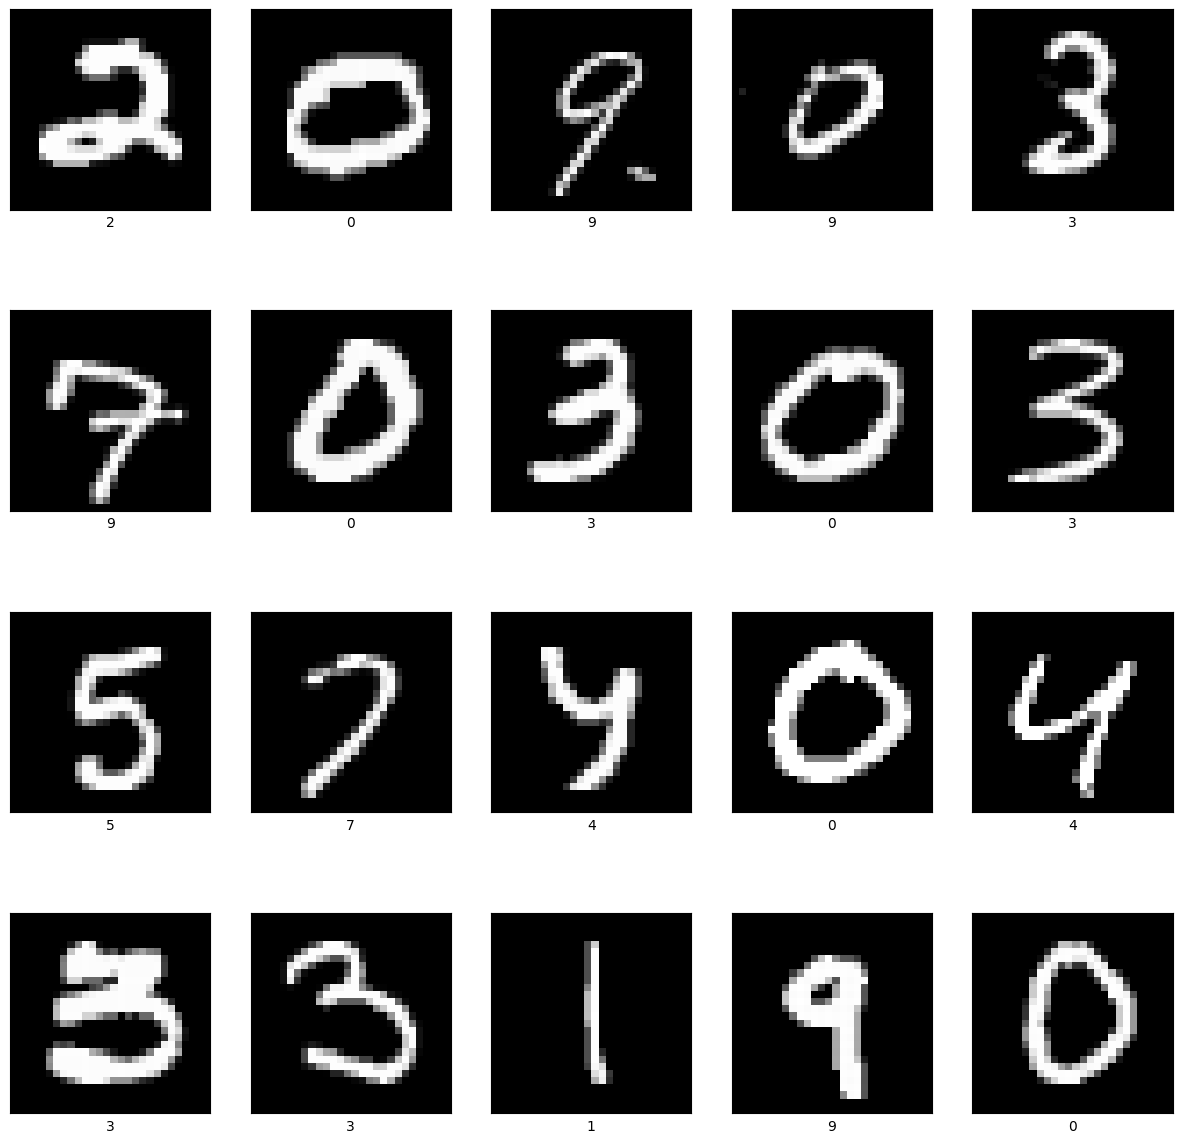

In [76]:
plt.figure(figsize=(15,15))
i = 0
for i, row in test_data.head(20).iterrows():
    plt.subplot(4,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(row.values.reshape((28, 28)), cmap='gray')
    plt.xlabel(result[i])

# 測測看自己寫的字

In [ ]:
from PIL import Image
import zipfile
import os

In [ ]:
from google.colab import files
files.upload() #上傳larger.zip

In [ ]:
zip_train = zipfile.ZipFile('/content/larger.zip', 'r') #Opens the zip file in read mode
zip_train.extractall('/content') #Extracts the files into the /tmp folder
zip_train.close()

In [ ]:
image_folder = '/content/larger'  # 資料夾的名稱

image_data = np.empty((0, 28 * 28), dtype=np.uint8)
labels = np.empty((0, 1), dtype=int)

for filename in os.listdir(image_folder):
    if filename.endswith(".png"):
        image = Image.open(os.path.join(image_folder, filename)).convert('L')
        image_array = np.array(image).flatten()
        label = int(filename.split(".")[0])
        labels = np.vstack((labels, label))
        image_data = np.vstack((image_data, image_array))

df = pd.DataFrame(data=image_data, columns=reduced_data.columns[1:785])

In [ ]:
df_test_data = tf.data.Dataset.from_tensor_slices(([df.to_numpy().reshape(len(df), 28, 28, 1)]))

predictions = model.predict(df_test_data)
predictions = np.argmax(predictions, axis=1)

In [ ]:
plt.figure(figsize=(10,10))

for i, row in df.head(10).iterrows():
    plt.subplot(2,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)

    plt.imshow(row.values.reshape((28, 28)), cmap='gray')
    plt.xlabel(predictions[i])